In [1]:
import calendar
from builtins import frozenset

import pandas as pd
import matplotlib.pyplot as plt

from src.model.models import Surebet
import matplotlib.dates as mdates
from typing import List
import matplotlib
from src.repository.surebet_repository import SurebetRepository

### Código para gerar gráficos

In [2]:
def config_plot(plt: matplotlib.pyplot):
    # Defina o tamanho da figura (largura x altura) em polegadas
    largura_figura = 20  # Ajuste a largura
    altura_figura = 6    # Ajuste a altura
    plt.figure(figsize=(largura_figura, altura_figura))
    plt.xticks(rotation=90)

def plotar(df: pd.DataFrame, eixos: tuple, title='Gráfico de Surebet por data'):
    plt = matplotlib.pyplot
    config_plot(plt)
    plt.ylabel('Quantidade Surebet')
    plt.title(title)
    # df = df.query(f'{eixos[1]} != 0')
    # plt.scatter(df[f'{eixos[0]}'], df[f'{eixos[1]}'])
    plt.bar(df[f'{eixos[0]}'], df[f'{eixos[1]}'])

    for i, valor in enumerate(df[f'{eixos[1]}']):
        plt.text(i, valor + 0.1, str(valor), ha='center')
    
    plt.show()

In [3]:
repository = SurebetRepository()


Frequência por dia:
'D' ou '1D' para intervalos de um dia.

Frequência por hora:
'H' ou '1H' para intervalos de uma hora.

Frequência por minuto:
'T' ou '1T' para intervalos de um minuto.

Frequência por segundo:
'S' ou '1S' para intervalos de um segundo.

Frequência por semana:
'W' ou '1W' para intervalos de uma semana.

Frequência por mês:
'M' ou '1M' para intervalos de um mês (final do mês).

Frequência por trimestre:
'Q' ou '3M' para intervalos de trimestre.

Frequência por ano:
'Y' ou '1Y' para intervalos de um ano.

In [4]:
def list_to_dataframe(dados: List[Surebet]) -> pd.DataFrame:
    df = pd.DataFrame.from_records([vars(i) for i in dados])
    df = df[['game_id', 'bookmaker_key_OVER', 'bookmaker_key_UNDER', 'odd_OVER', 'odd_UNDER', 'last_update_OVER', 'last_update_UNDER', 'profit']]
    return df


def setar_intervalo_df(df: pd.DataFrame, interval: tuple, freq: str, is_monthly = False):
    """
    Define intervalos de tempo em um DataFrame com base em um range e uma frequência.

    Esta função recebe um DataFrame, um range de datas e uma frequência e cria uma nova coluna
    no DataFrame que associa cada registro a um intervalo de tempo correspondente.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados a serem processados.
        interval (tuple): Uma tupla que especifica o início e o fim do intervalo de datas no formato 'AAAA-MM-DD'.
        freq (str): Uma string que especifica a frequência para criar os intervalos de tempo, por exemplo, '1H' para 1 hora.

    Returns:
        None: A função modifica o DataFrame original, adicionando a coluna 'Intervalo' com os intervalos correspondentes.
    """
    
    # Definir os intervalos manualmente 
    intervalos = []
    if is_monthly:    
        for i in range(1, 13):
            last_day_month = calendar.monthrange(2023, i)[1]
            intervalos.extend(list(pd.date_range(start=f'2023-{i}-01', end=f'2023-{i}-{last_day_month}', freq=(str(last_day_month - 1)) + 'D')))
    else:
        intervalos = pd.date_range(start=f'{interval[0]}', end=f'{interval[1]}', freq=f'{freq}')
    
    # Arredondando os minutos com base nos segundos
    # df['last_update_OVER'] = df['last_update_OVER'].dt.round('T')  todo testano outras formas de arredondar, voltar esse código depois
    # df['last_update_OVER'] = df['last_update_OVER'].dt.floor('T')

    posicao = df.columns.get_loc('last_update_UNDER')  # Obtém o índice da coluna 'last_update_UNDER'
    
    # Criar uma nova coluna com o intervalo correspondente a cada registro
    df.insert(posicao, 'intervalo', pd.cut(df['last_update_OVER'], bins=intervalos))


In [5]:
from datetime import datetime

from enum import Enum

class IntervaloTemporal(Enum):
    MES = 1
    DIA = 2
    HORA = 3
    MINUTO = 4


class ConfigPlot:
    def __init__(self, intervalo, data_inicial, data_final):
        self.intervalo = intervalo
        self.mascara_data = self.get_mascara_data(intervalo)
        self.data_inicial = data_inicial
        self.data_final = data_final

    def get_mascara_data(self, intervalo):
        mes = ['M', '30D', '31D']
        if intervalo in mes:
            return '%m-%Y'
        elif 'D' in intervalo:
            return '%d-%m-%Y'
        elif 'H' in intervalo or 'T' in intervalo:
            return '%H:%M:%S'
        else:
            raise ValueError("Intervalo não suportado")

def criar_config_plot(intervalo, data_inicial, data_final):
    return ConfigPlot(intervalo, data_inicial, data_final)

def gerar_plot_surebet(config: ConfigPlot, intervalo: IntervaloTemporal, title=''):
    lista_surebet = repository.find_all_unique_between(config.data_inicial, config.data_final)
    df = list_to_dataframe(lista_surebet)
    setar_intervalo_df(df, (config.data_inicial, config.data_final), config.intervalo, is_monthly = (intervalo == IntervaloTemporal.MES))
    
    # Agrupando a quantidade de surebets pelo intervalo
    resultado = df.groupby('intervalo').size().reset_index(name='quantidade')
    df_to_plot = pd.DataFrame({'intervalo': resultado['intervalo'].apply(lambda x: x.left.strftime(config.mascara_data)), 'quantidade': resultado['quantidade']})
    
    # print(df_to_plot.head().to_string())
    
    if intervalo == IntervaloTemporal.HORA or intervalo == IntervaloTemporal.MINUTO:
        df_to_plot = pd.DataFrame({'intervalo': resultado['intervalo'].apply(lambda x: x.left.strftime(config.mascara_data) + ' - ' + x.right.strftime(config.mascara_data)), 'quantidade': resultado['quantidade']})

    # print(df_to_plot.head().to_string())
    if intervalo == IntervaloTemporal.MES:  # Somando os intervalos para não ficar com dois registros por mês ex: 01-01 e 31-01
        df_to_plot = df_to_plot.groupby('intervalo').sum().reset_index()
    
    plotar(df_to_plot, ('intervalo', 'quantidade'), title=title)


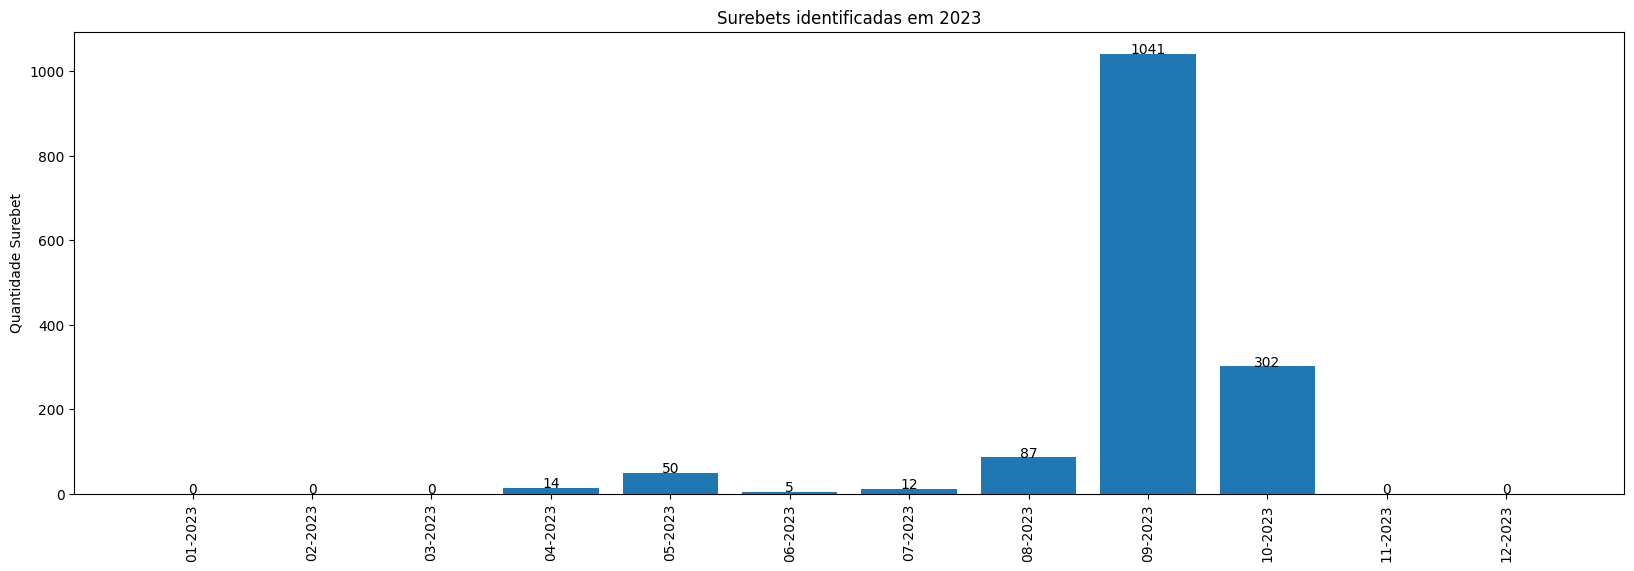

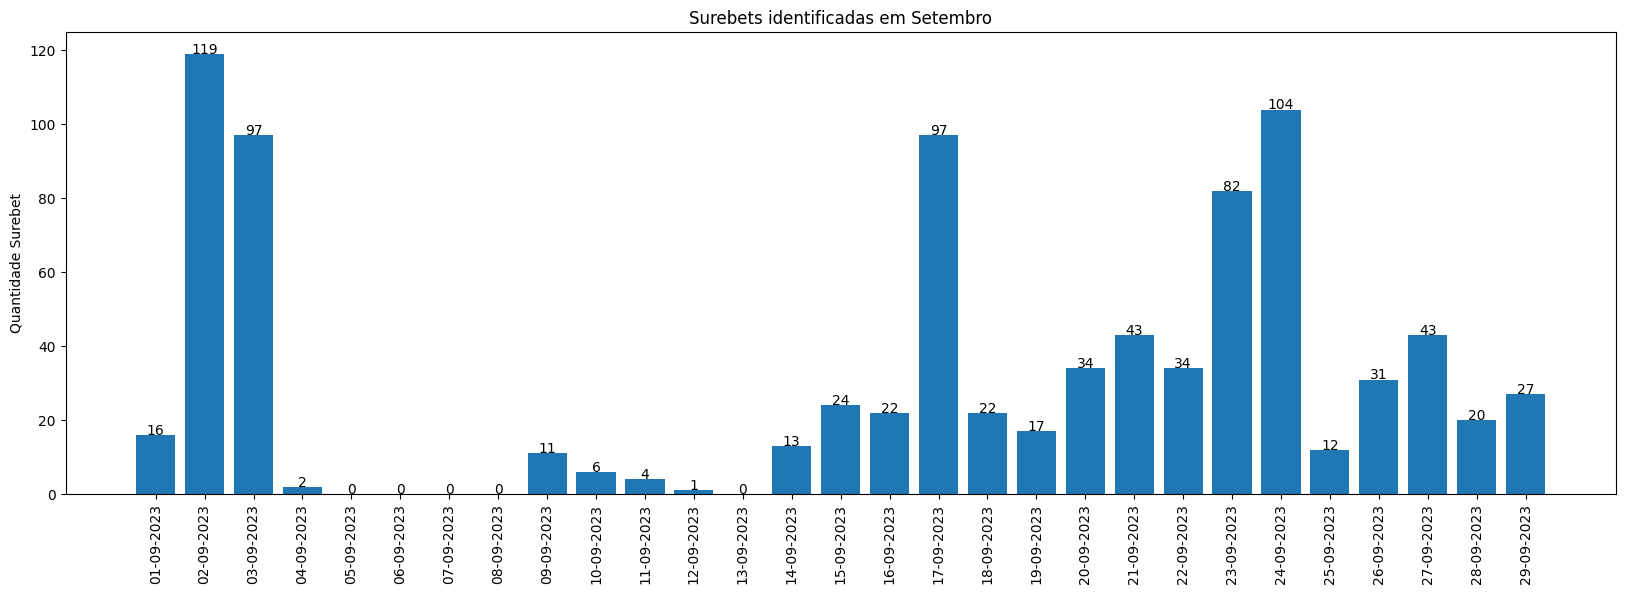

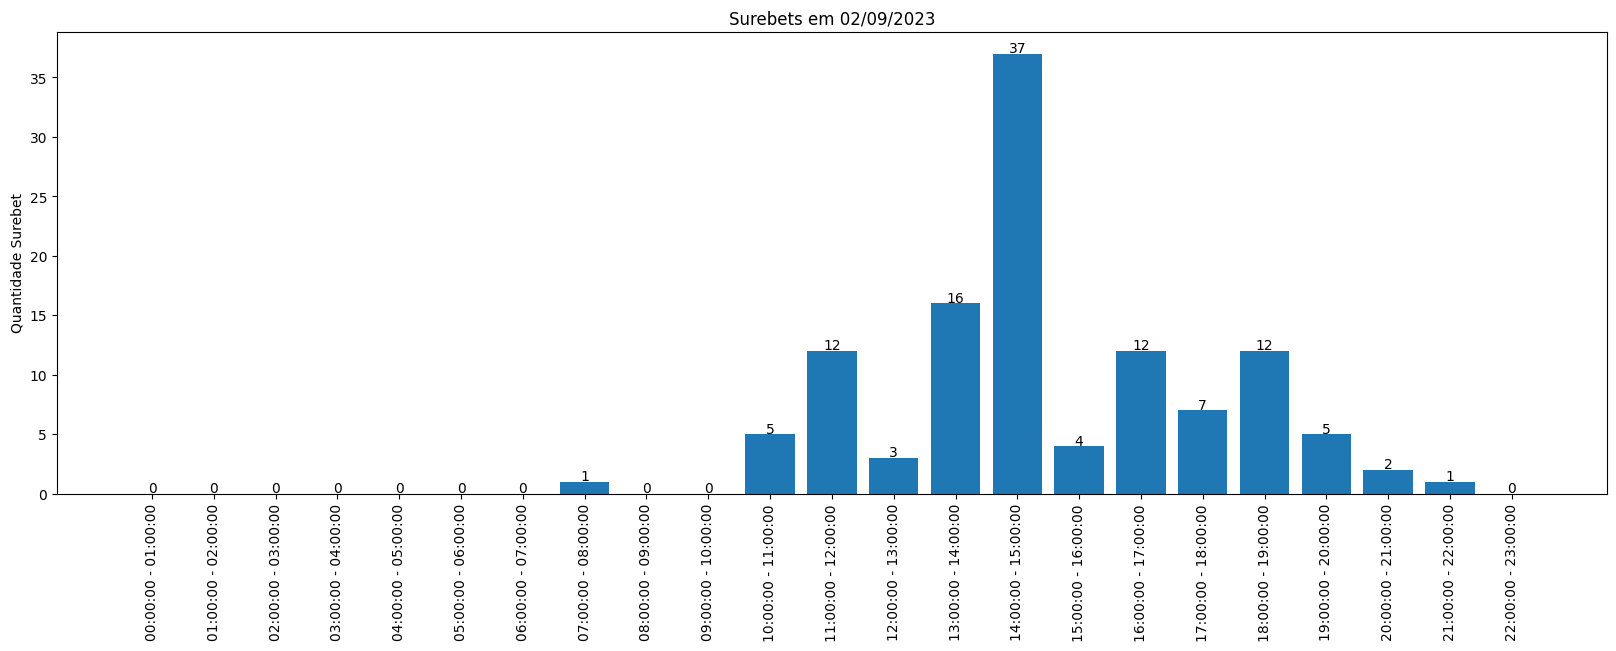

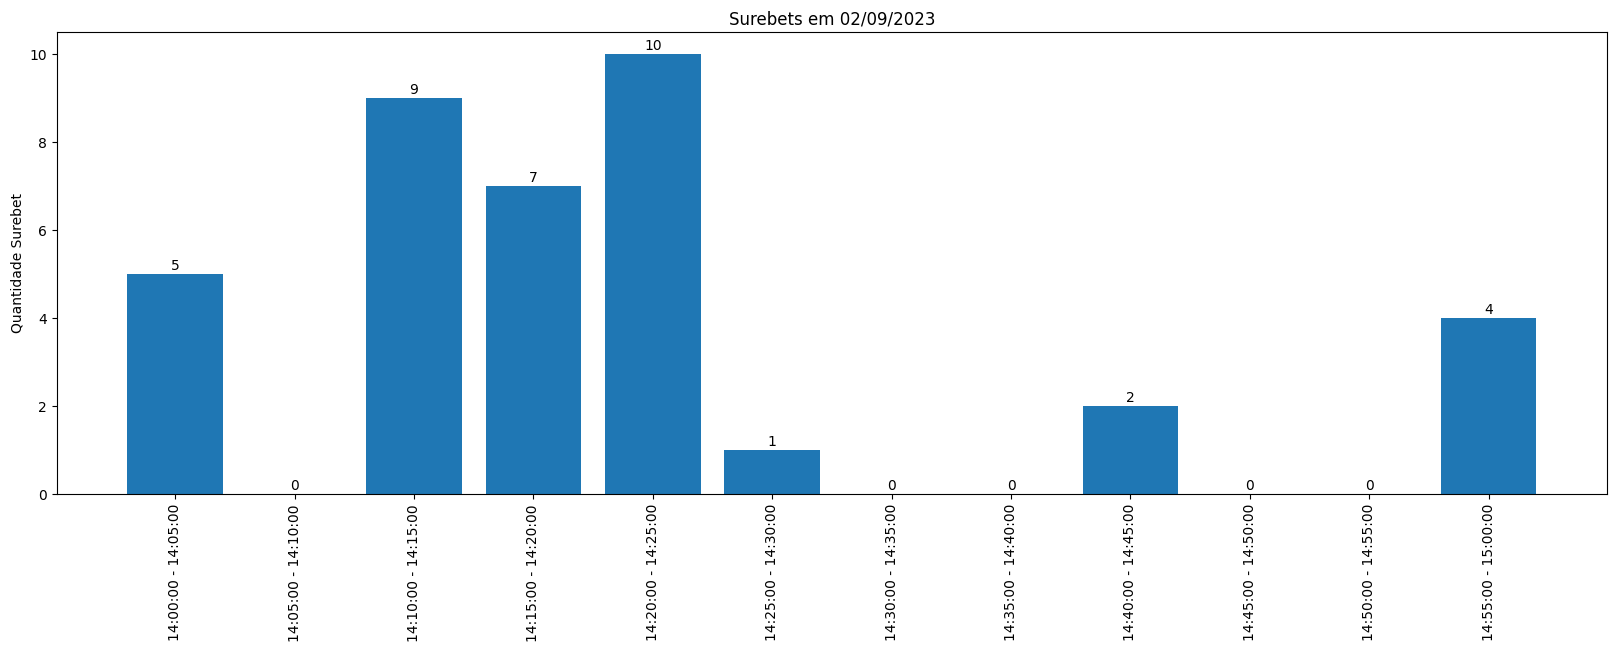

In [6]:
meses = ConfigPlot('30D', '2023-01-01', '2023-12-31')
gerar_plot_surebet(meses, intervalo=IntervaloTemporal.MES, title='Surebets identificadas em 2023')

dias = ConfigPlot('1D', '2023-09-01 00:00:00', '2023-09-30 23:59:59')
gerar_plot_surebet(dias, intervalo=IntervaloTemporal.DIA, title='Surebets identificadas em Setembro')

horas = ConfigPlot('1H', '2023-09-02 00:00:00', '2023-09-02 23:59:59')
gerar_plot_surebet(horas, intervalo=IntervaloTemporal.HORA, title='Surebets em 02/09/2023')

minutos = ConfigPlot('5T', '2023-09-02 14:00:00', '2023-09-02 15:00:00')
# minutos = ConfigPlot('5T', '2023-09-02 14:00:00', '2023-09-02 14:05:00')
gerar_plot_surebet(minutos, intervalo=IntervaloTemporal.MINUTO, title='Surebets em 02/09/2023')

In [ ]:
dias = ConfigPlot('1D', '2023-08-01 00:00:00', '2023-08-31 23:59:59')
horas = ConfigPlot('1H', '2023-08-26 00:00:00', '2023-08-26 23:59:59')
minutos = ConfigPlot('5T', '2023-09-01 19:00:00', '2023-09-01 20:00:00')
gerar_plot_surebet(dias, False)
gerar_plot_surebet(horas, False)